In [2]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["0", "1"]

In [28]:
from google.colab import drive
drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/MyDrive/ML/waterQuality1.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
df.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [ ]:
# df = df.replace(["Male","Female"],[0,1])
# df = df.replace(["Yes","No"],[1,0])
# df = df.replace(["Caucasian","Asian","African American"],[0,1,2])

In [5]:
print(df.shape)
print(df.describe())

(7999, 21)
         aluminium      arsenic       barium      cadmium   chloramine  \
count  7999.000000  7999.000000  7999.000000  7999.000000  7999.000000   
mean      0.666158     0.161445     1.567715     0.042806     2.176831   
std       1.265145     0.252590     1.216091     0.036049     2.567027   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.040000     0.030000     0.560000     0.008000     0.100000   
50%       0.070000     0.050000     1.190000     0.040000     0.530000   
75%       0.280000     0.100000     2.480000     0.070000     4.240000   
max       5.050000     1.050000     4.940000     0.130000     8.680000   

          chromium       copper     flouride     bacteria      viruses  \
count  7999.000000  7999.000000  7999.000000  7999.000000  7999.000000   
mean      0.247226     0.805857     0.771565     0.319665     0.328583   
std       0.270640     0.653539     0.435373     0.329485     0.378096   
min       0.000000     0.0

In [6]:
df.isnull().values.any()

False

In [29]:
df = df.replace(["#NUM!", '1', '0'], [0,1,0])
#df = df.drop('ammonia', axis = 1)
df["ammonia"] = df["ammonia"].astype(float)
df["is_safe"] = df["is_safe"].astype(float)

<ipython-input-29-a9f6ece31ca7>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(["#NUM!", '1', '0'], [0,1,0])


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   float64
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

In [9]:
df['is_safe'].value_counts()

,count
is_safe,
0.0,7087
1.0,912


<ipython-input-10-215a13f56ef0>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['is_safe'], sort = True)


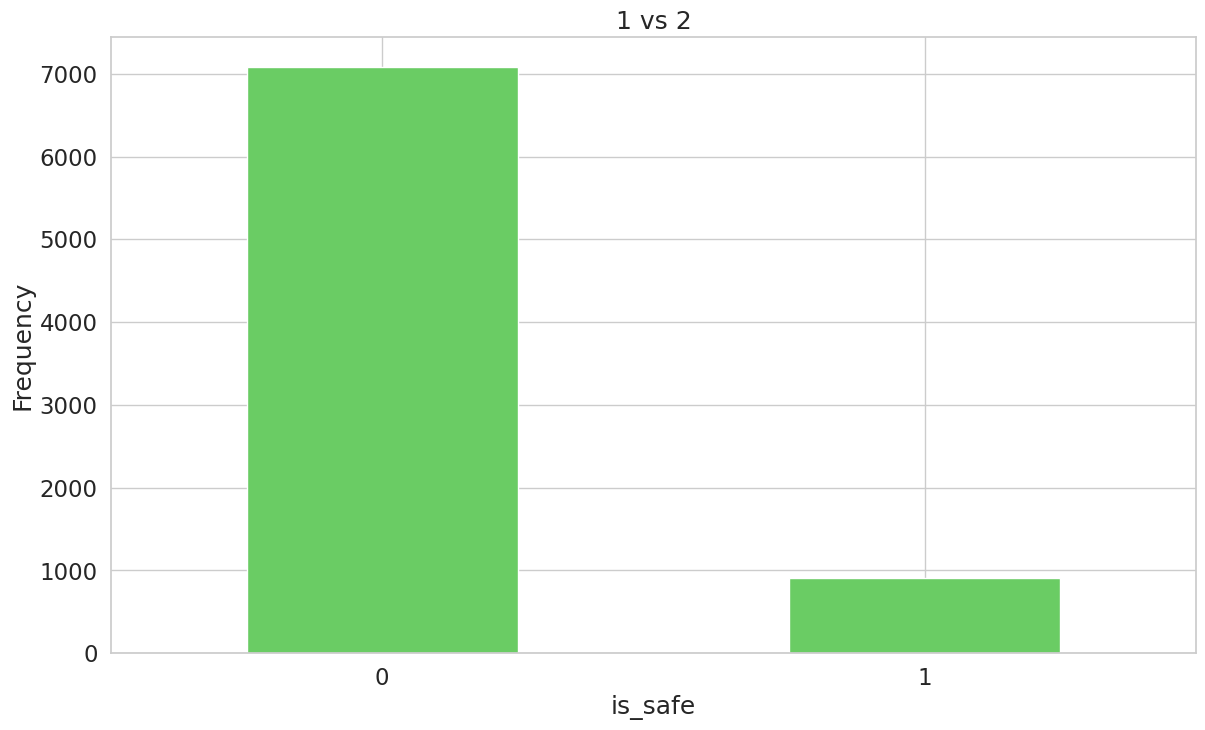

In [10]:
count_classes = pd.value_counts(df['is_safe'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("1 vs 2")
plt.xticks(range(2), LABELS)
plt.xlabel("is_safe")
plt.ylabel("Frequency");

In [30]:
transactionData = df.copy()

In [ ]:
# transactionData['perchlorate'] = StandardScaler().fit_transform(transactionData['perchlorate'].values.reshape(-1, 1))
# transactionData['radium'] = StandardScaler().fit_transform(transactionData['radium'].values.reshape(-1, 1))
# transactionData['nitrates'] = StandardScaler().fit_transform(transactionData['nitrates'].values.reshape(-1, 1))
# transactionData['ammonia'] = StandardScaler().fit_transform(transactionData['ammonia'].values.reshape(-1, 1))

In [31]:
scaler = StandardScaler()
transactionData_scaled = pd.DataFrame(scaler.fit_transform(transactionData), columns=transactionData.columns)
print(transactionData_scaled)

      aluminium   ammonia   arsenic    barium   cadmium  chloramine  chromium  \
0      0.777700 -0.584714 -0.480829  1.054498 -0.993313   -0.711697  2.153450   
1      1.307316  0.775491 -0.599606  1.432783 -1.132020    1.208933  1.599174   
2      0.271797 -0.028472 -0.480829 -0.812255 -0.965571    0.803769  1.044899   
3      0.548463 -0.331365 -0.480829  1.144957 -1.159762    1.968614 -0.802687   
4      0.200655  1.132432 -0.520421 -1.124751 -1.021054    0.192129  1.636126   
...         ...       ...       ...       ...       ...         ...       ...   
7994  -0.487056 -0.731094 -0.639198  0.314375 -0.077845   -0.809092 -0.802687   
7995  -0.487056  1.120046 -0.560013 -0.804032 -0.910089   -0.672739 -0.839639   
7996  -0.455437 -0.835812 -0.639198 -0.787584 -0.355260   -0.828571 -0.728783   
7997  -0.518675 -0.481123 -0.599606  0.355493 -1.187503   -0.068890 -0.913542   
7998  -0.494961 -0.835812 -0.599606 -0.713572 -0.355260   -0.828571 -0.876590   

        copper  flouride  b

In [32]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.is_safe == 0]
X_train = X_train.drop(['is_safe'], axis=1)
#print(type(X_train))
y_test = X_test['is_safe']
X_test = X_test.drop(['is_safe'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)

1600


In [33]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(20, 10),
            nn.Tanh(),
            nn.Linear(10, 5),
            nn.LeakyReLU(),
            )

        self.decoder = nn.Sequential(
           nn.Linear(5,5),
           nn.Tanh(),
           nn.Linear(5, 20),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [34]:
model = Autoencoder().double()
#model = Autoencoder().double().cpu()

In [35]:
num_epochs = 200   # сколько эпох будем обучать. Результаты обучения на одной эпохе используются как начальные для следующей.
minibatch_size = 32
learning_rate = 1e-3

In [36]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)

In [37]:
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [39]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [40]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())

        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)


torch.save(model.state_dict(), './credit_card_model.pth')

epoch [1/200], loss:48.6463
epoch [2/200], loss:43.3605
epoch [3/200], loss:39.6728
epoch [4/200], loss:36.7326
epoch [5/200], loss:34.2696
epoch [6/200], loss:32.1554
epoch [7/200], loss:30.3420
epoch [8/200], loss:28.5589
epoch [9/200], loss:27.0114
epoch [10/200], loss:25.6363
epoch [11/200], loss:24.4198
epoch [12/200], loss:23.3164
epoch [13/200], loss:22.3014
epoch [14/200], loss:21.3466
epoch [15/200], loss:20.4833
epoch [16/200], loss:19.6555
epoch [17/200], loss:18.8553
epoch [18/200], loss:18.1016
epoch [19/200], loss:17.3952
epoch [20/200], loss:16.7306
epoch [21/200], loss:16.0908
epoch [22/200], loss:15.4792
epoch [23/200], loss:14.9019
epoch [24/200], loss:14.3620
epoch [25/200], loss:13.8110
epoch [26/200], loss:13.2675
epoch [27/200], loss:12.7078
epoch [28/200], loss:12.1108
epoch [29/200], loss:11.5128
epoch [30/200], loss:10.8931
epoch [31/200], loss:10.2996
epoch [32/200], loss:9.7136
epoch [33/200], loss:9.1590
epoch [34/200], loss:8.6351
epoch [35/200], loss:8.141

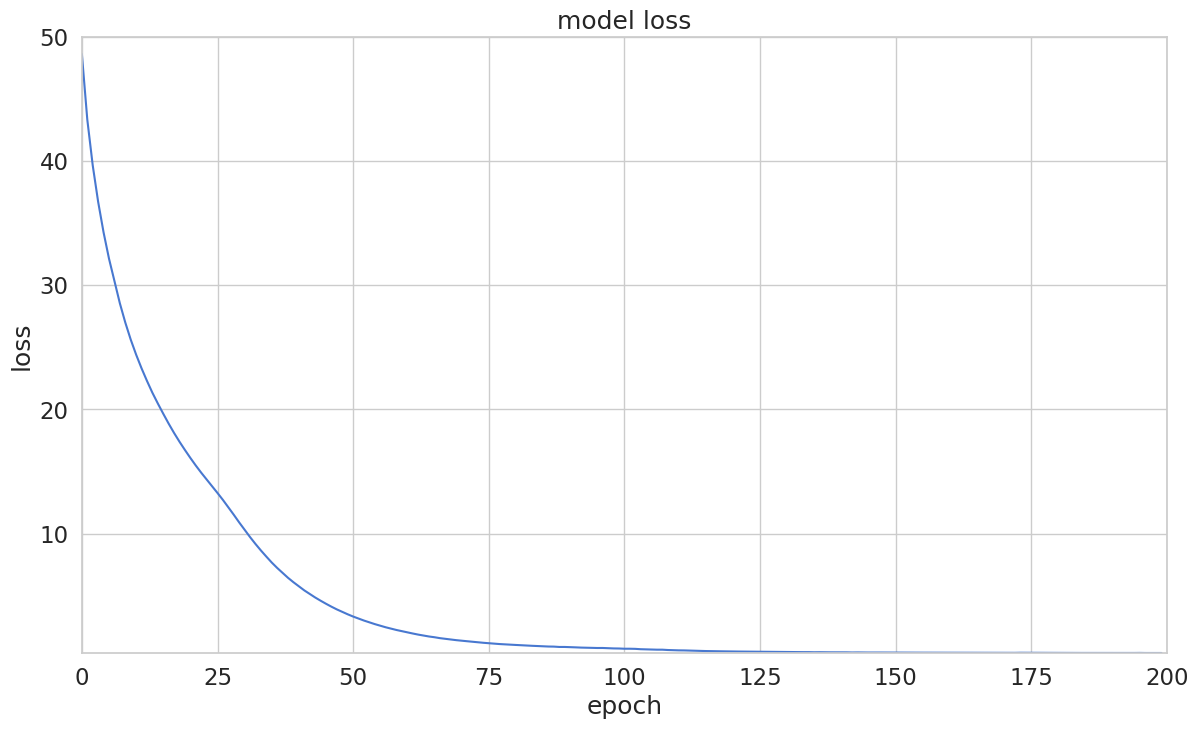

In [41]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,200,0.35,50])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

In [42]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['is_safe'] = y_test

In [43]:
reconstructionErrorDF.describe()

,pred_loss,is_safe
count,1600.000000,1600.000000
mean,0.409755,0.125000
std,0.413882,0.330822
min,0.011867,0.000000
25%,0.113284,0.000000
50%,0.241753,0.000000
75%,0.563227,0.000000
max,2.709951,1.000000


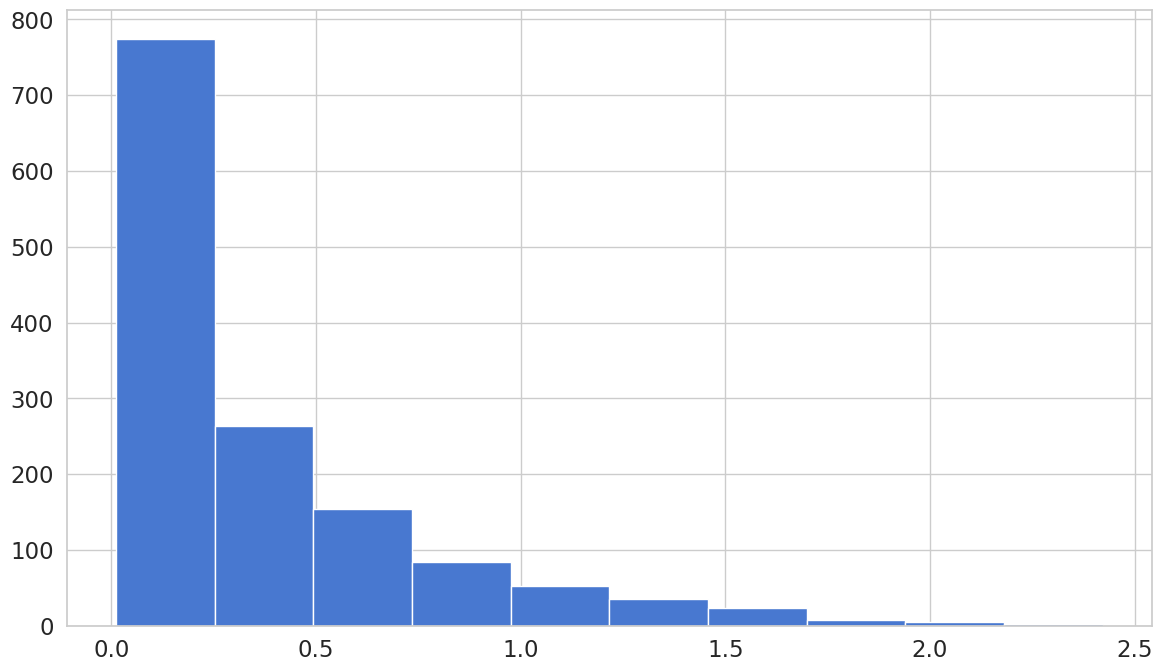

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['is_safe']== 0) & (reconstructionErrorDF['pred_loss'] < 50)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

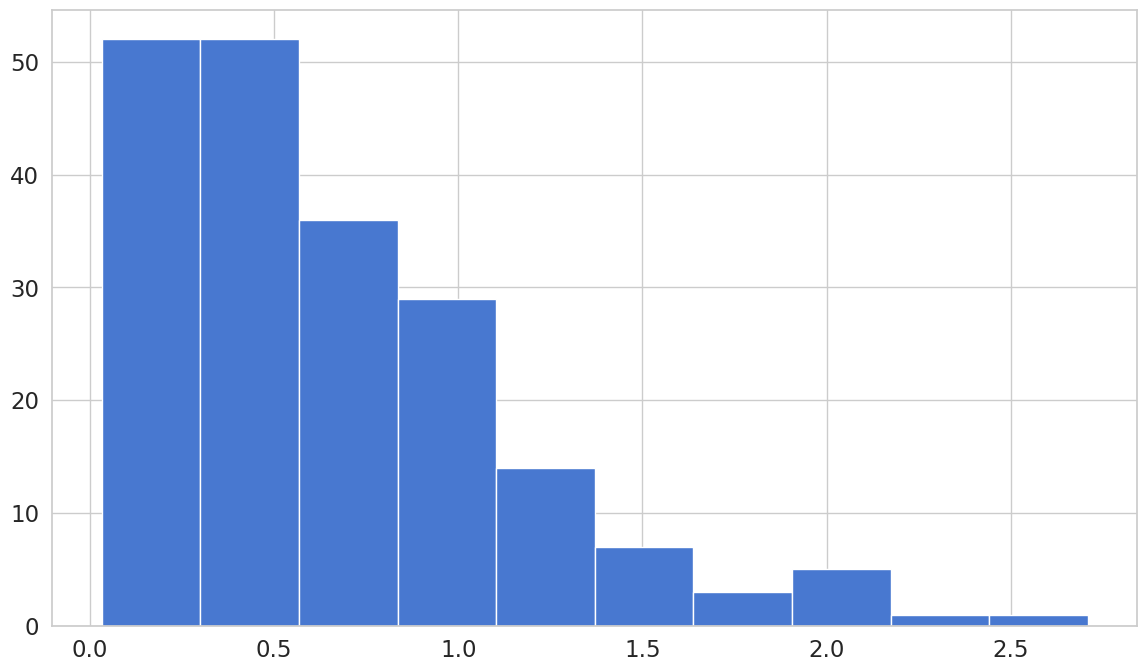

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['is_safe']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

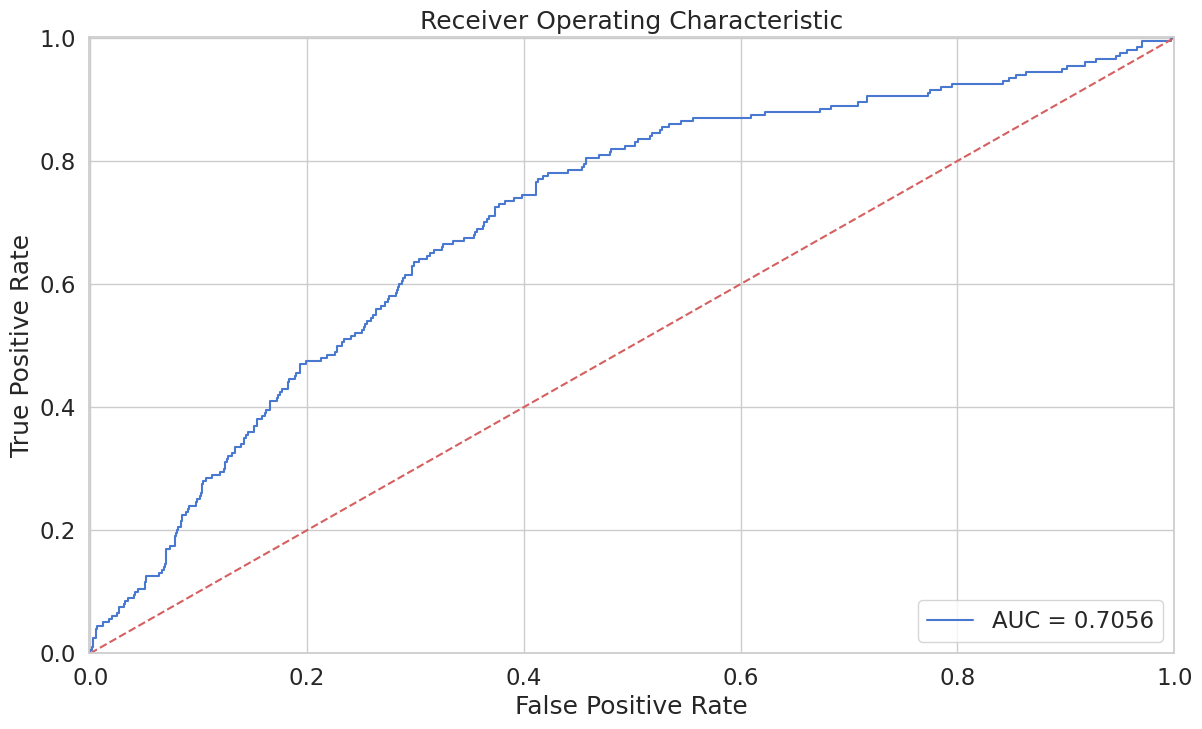

In [49]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.is_safe, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

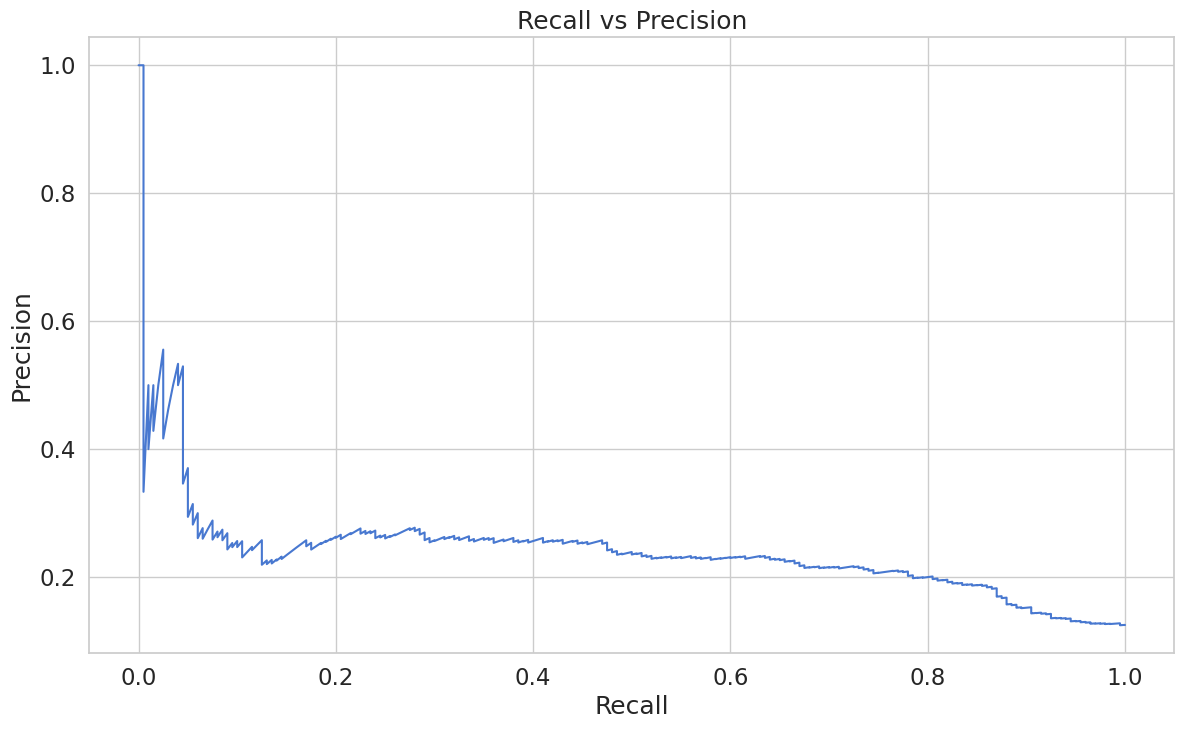

In [50]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.is_safe, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

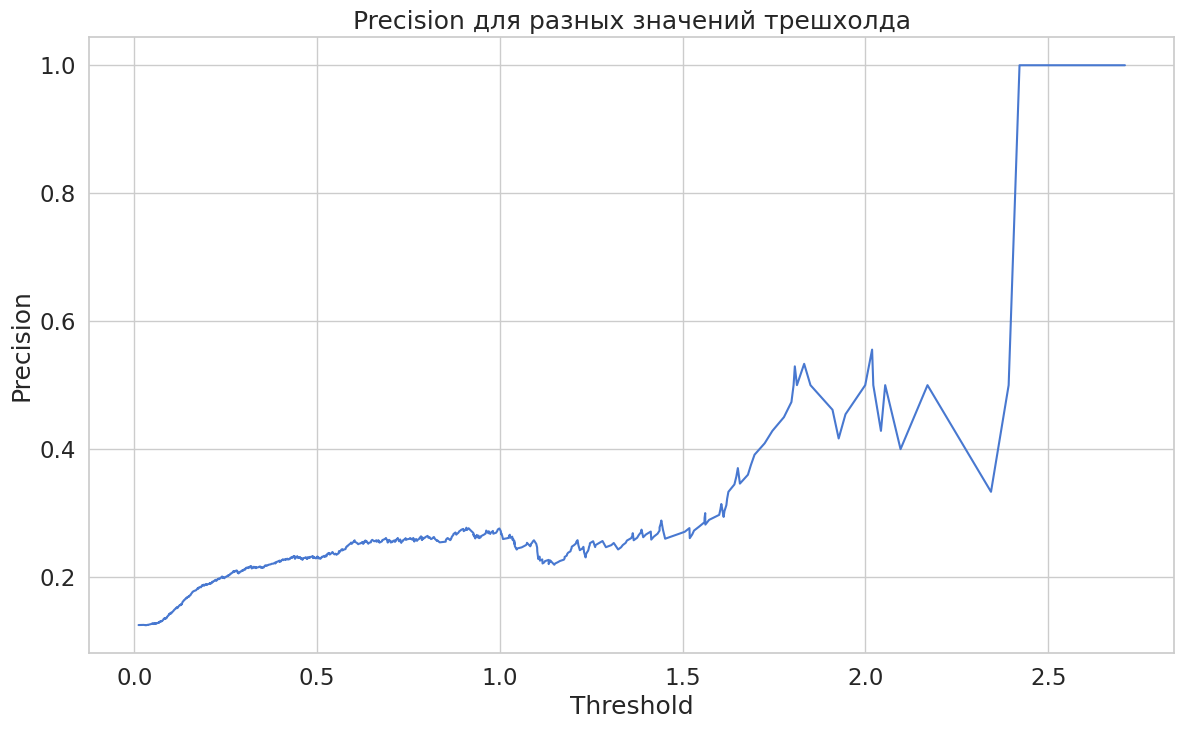

In [52]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision для разных значений трешхолда')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

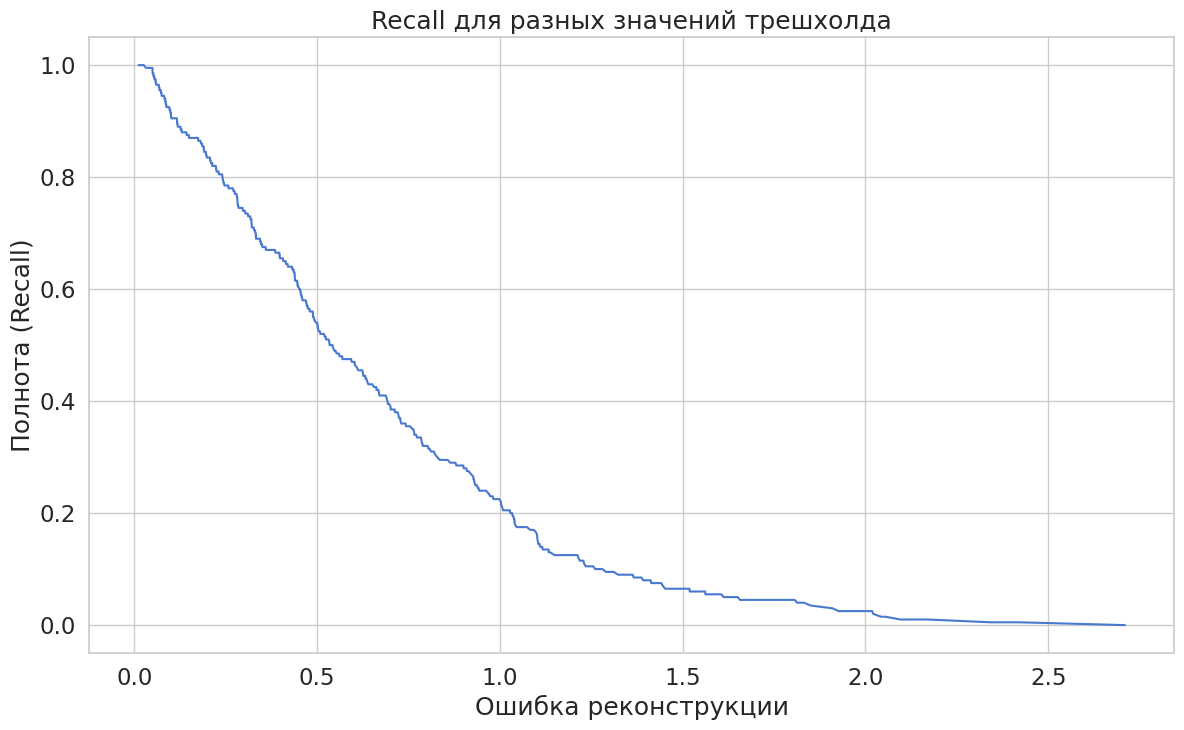

In [53]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall для разных значений трешхолда')
plt.xlabel('Ошибка реконструкции')
plt.ylabel('Полнота (Recall)')
plt.show()

In [64]:
threshold = 0.5

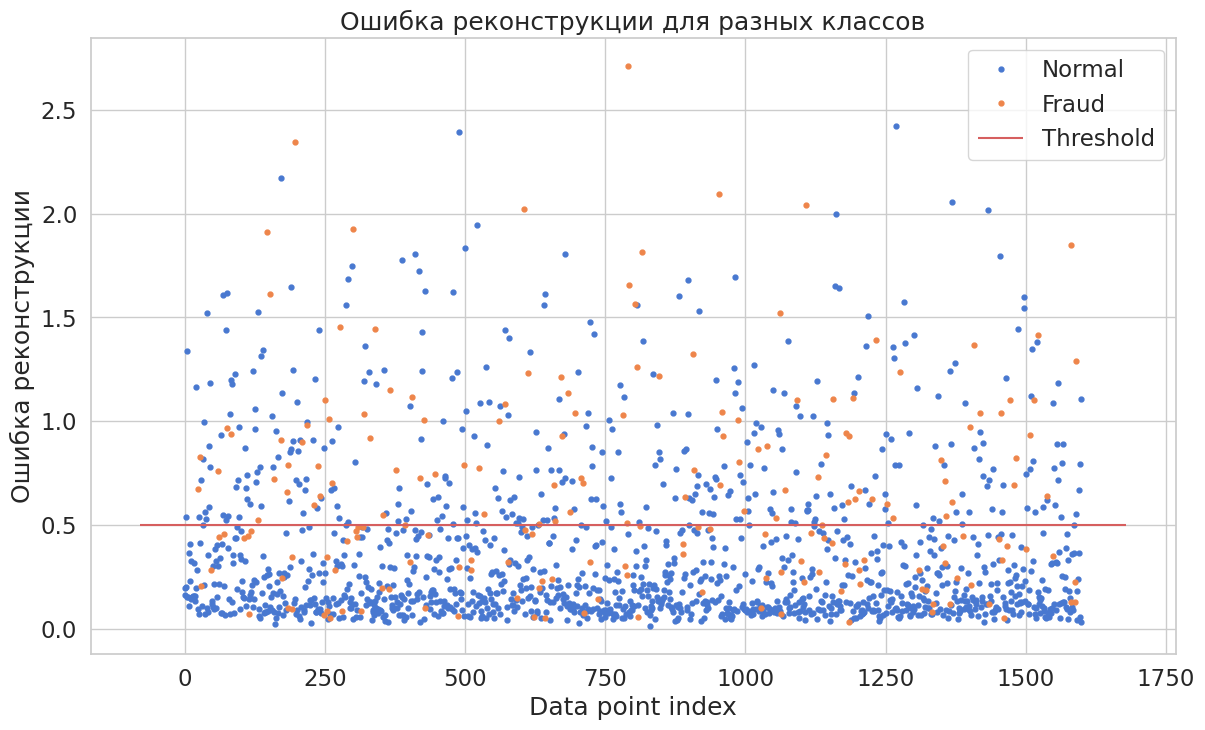

In [65]:
groups = reconstructionErrorDF.groupby('is_safe')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Ошибка реконструкции для разных классов")
plt.ylabel("Ошибка реконструкции")
plt.xlabel("Data point index")
plt.show();

<ipython-input-66-d20773bcacd3>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues'));


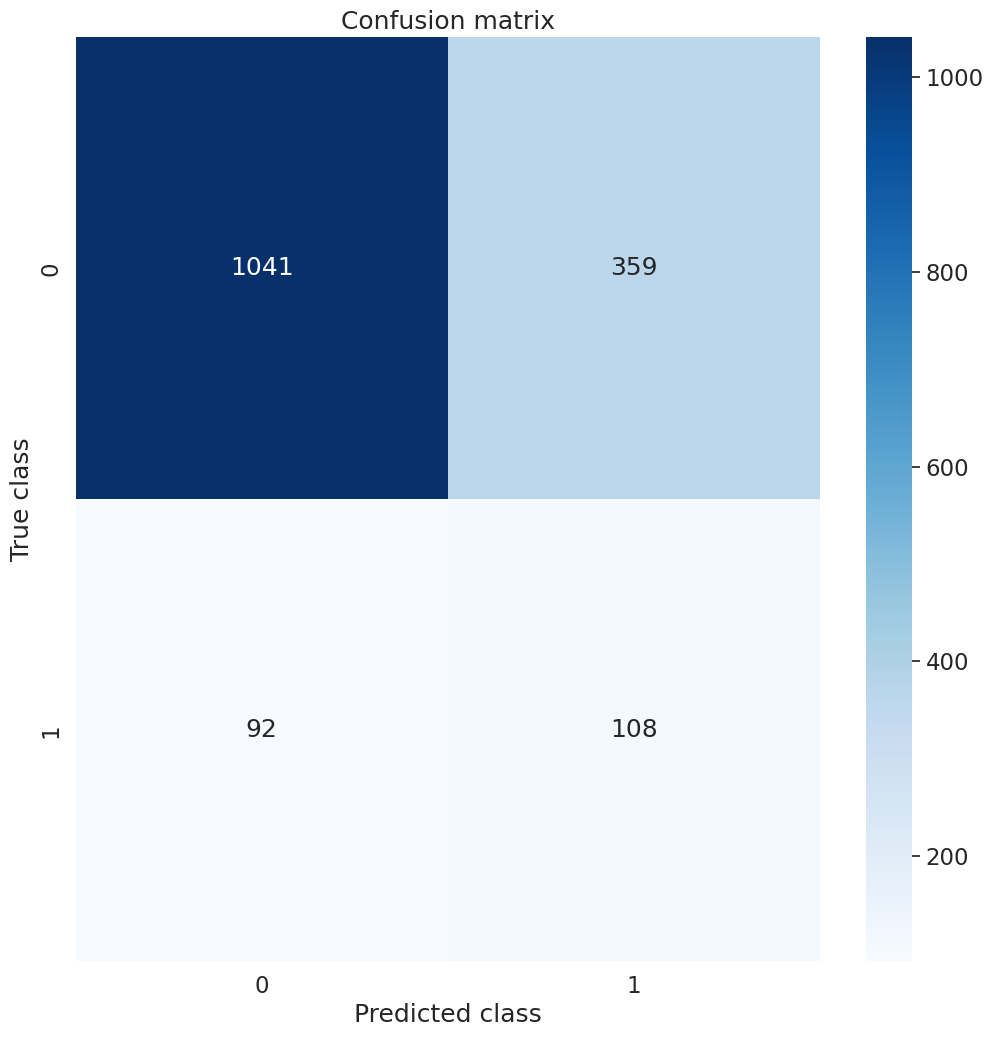

In [66]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.is_safe, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()